In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

np.random.seed(1)
tf.random.set_seed(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.13.0


In [27]:
df=pd.read_csv('/Users/rianrachmanto/pypro/data/esp_new.csv')
print(df.head())

  Well        Date  Hours_Online  Freq  Ampere   Volt  Press_Discharge     TM  \
0  BC1  2011-09-02          24.0   NaN    19.2  343.2              NaN  175.0   
1  BC1  2011-09-03          24.0   NaN    18.3  339.6              NaN  177.4   
2  BC1  2011-09-04          24.0   NaN    18.0  341.0              NaN  177.0   
3  BC1  2011-09-05          24.0   NaN    19.2  343.0              NaN  178.0   
4  BC1  2011-09-06          24.0   NaN    18.3  339.6              NaN  178.4   

   Vibration   Gross_Rate  
0      2.795  1577.005714  
1      2.670  1577.005714  
2      2.711  1577.005714  
3      2.641  1577.005714  
4      2.500  1577.005714  


In [28]:
#filter to only use data by Well BS3
df = df[df['Well'] == 'BS3']
df=df[['Date','Freq']]
print(df.head())
#convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes)

            Date  Freq
9277  2011-09-01   NaN
9278  2011-09-02   NaN
9279  2011-09-03   NaN
9280  2011-09-04   NaN
9281  2011-09-05   NaN
Date    datetime64[ns]
Freq           float64
dtype: object


In [29]:
df['Date'].min(), df['Date'].max()

(Timestamp('2011-09-01 00:00:00'), Timestamp('2024-05-13 00:00:00'))

In [30]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['Date'], y=df['Freq'], name='Frequency'))
fig.update_layout(showlegend=True, title='BS3 Frequency Data')
fig.show()


In [31]:
#train test split based on length
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [32]:
#dropna on train and test
train = train.dropna()
test = test.dropna()

In [33]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Freq']])

train['Freq'] = scaler.transform(train[['Freq']])
test['Freq'] = scaler.transform(test[['Freq']])

In [34]:
TIME_STEPS=24

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Freq']], train['Freq'])
X_test, y_test = create_sequences(test[['Freq']], test['Freq'])

In [35]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (653, 24, 1)
Testing shape: (547, 24, 1)


In [36]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_1 (RepeatVec  (None, 24, 128)           0         
 tor)                                                            
                                                                 
 lstm_3 (LSTM)               (None, 24, 128)           131584    
                                                                 
 dropout_3 (Dropout)         (None, 24, 128)           0         
                                                                 
 time_distributed_1 (TimeDi  (None, 24, 1)             129       
 stributed)                                           

In [37]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/100
19/19 [==============================] - 10s 223ms/step - loss: 0.1841 - val_loss: 0.2765
Epoch 2/100
19/19 [==============================] - 0s 19ms/step - loss: 0.1977 - val_loss: 0.2259
Epoch 3/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1801 - val_loss: 0.4740
Epoch 4/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1862 - val_loss: 0.3705
Epoch 5/100
19/19 [==============================] - 0s 18ms/step - loss: 0.1963 - val_loss: 0.3318


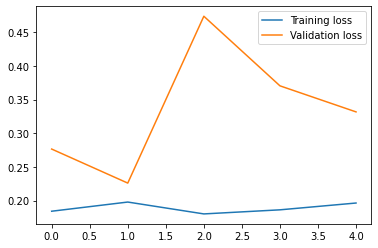

In [38]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [39]:
model.evaluate(X_test, y_test)

18/18 [==============================] - 1s 51ms/step - loss: 0.2507


0.2506903111934662

Reconstruction error threshold: 1.1583949776421296


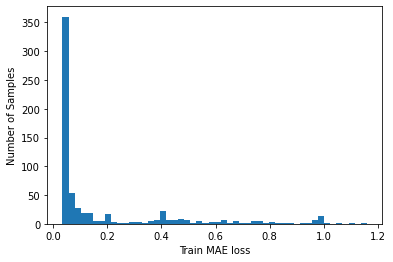

In [40]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

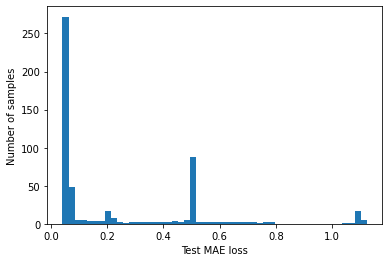

In [41]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [42]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Freq'] = test[TIME_STEPS:]['Freq']

In [43]:
test_score_df.tail()

,Date,Freq,loss,threshold,anomaly
13911,2024-05-09,-0.623682,0.506582,1.158395,False
13912,2024-05-10,-0.623682,0.506582,1.158395,False
13913,2024-05-11,-0.623682,0.506582,1.158395,False
13914,2024-05-12,-0.623682,0.506582,1.158395,False
13915,2024-05-13,-0.623682,0.506582,1.158395,False


In [44]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()


In [45]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Date,Freq,loss,threshold,anomaly


In [46]:
anomalies.shape

(0, 5)

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=scaler.inverse_transform(test_score_df['Freq']), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=scaler.inverse_transform(anomalies['Freq']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  6.98490635e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  2.48753601e+01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  6.88846597e-02  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01 -1.12736669e+00 -1.12736669e+00 -1.12736669e+00
 -1.12736669e+00 -1.00144550e+00 -9.38484901e-01 -1.00144550e+00
 -1.00144550e+00 -1.00144550e+00 -1.00144550e+00 -9.38484901e-01
 -9.38484901e-01 -9.38484901e-01 -8.75524304e-01 -9.38484901e-01
 -9.38484901e-01 -9.38484901e-01 -9.38484901e-01 -9.38484901e-01
 -8.75524304e-01 -8.75524304e-01 -7.49603108e-01 -6.86642511e-01
 -6.23681913e-01 -5.60721316e-01 -4.97760718e-01 -4.97760718e-01
 -4.97760718e-01 -4.97760718e-01 -4.34800121e-01 -4.34800121e-01
 -3.08878926e-01 -3.08878926e-01 -2.45918328e-01 -1.82957731e-01
 -1.19997133e-01 -5.70365354e-02  5.92406213e-03  6.88846597e-02
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01 -1.82957731e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01 -4.97760718e-01 -4.97760718e-01 -4.97760718e-01
 -4.97760718e-01 -4.97760718e-01 -1.19997133e-01 -4.97760718e-01
 -1.82957731e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01  1.31845257e-01  1.31845257e-01  1.31845257e-01
  1.31845257e-01 -1.12736669e+00 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01
 -6.23681913e-01 -6.23681913e-01 -6.23681913e-01].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.